# Intel Image Classification

By Aviya Oren and Maya Hayat

This Data contains around 25k images of size 150x150 distributed under 6 categories.
1. 'buildings'
2. 'forest'
3. 'glacier'
4. 'mountain'
5. 'sea'
6. 'street'

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import random

import cv2
import imghdr
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

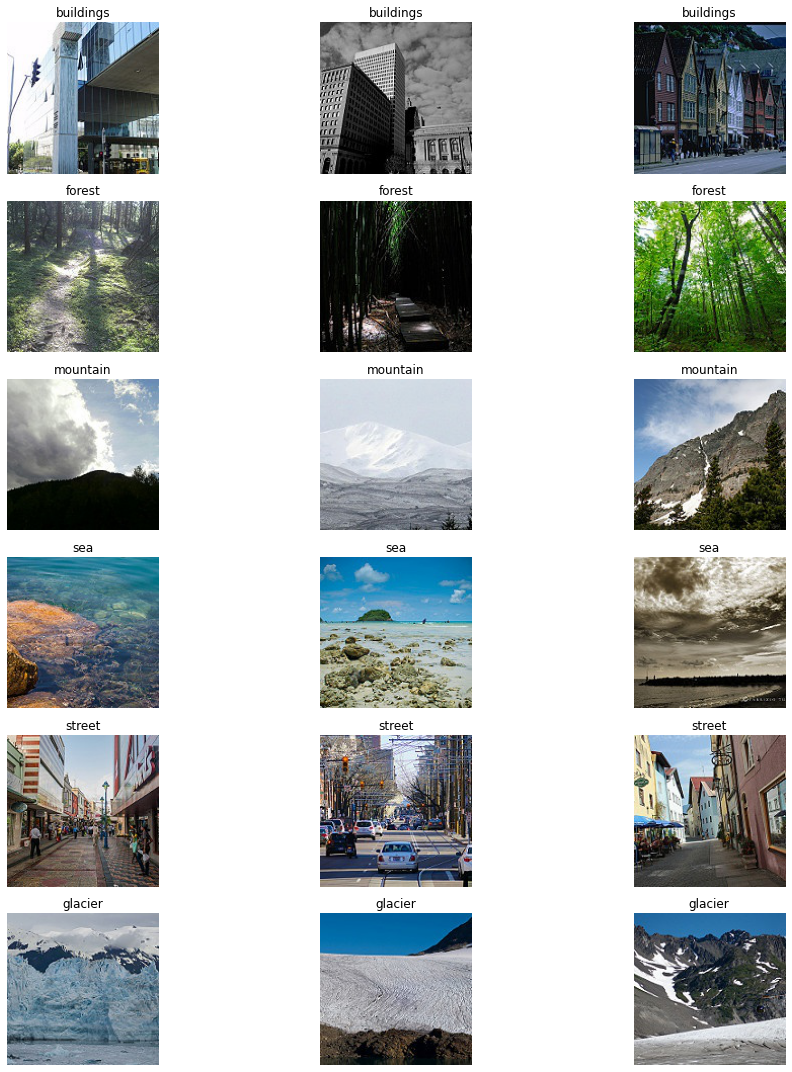

In [93]:
# Path to the directory containing the images
base_directory =  r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_train\seg_train'

# Categories
categories = ['buildings', 'forest', 'mountain', 'sea', 'street', 'glacier']

# Display three random images for each category
fig, axs = plt.subplots(len(categories), 3, figsize=(15, 15))

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('jpg'))]
    random_images = random.sample(image_files, 3)

    for j, image_file in enumerate(random_images):
        image_path = os.path.join(category_directory, image_file)
        image = mpimg.imread(image_path)
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(category)
        

plt.tight_layout()
plt.show()


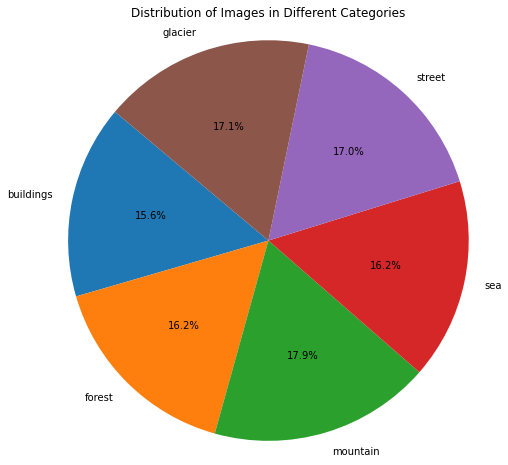

In [94]:
# Count the number of images in each category
sizes = []
for category in categories:
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    sizes.append(len(image_files))

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=categories, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Images in Different Categories')
plt.show()


In [3]:
data_directory = r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_train\seg_train'

In [4]:
test_data = r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_test\seg_test'

In [5]:
os.listdir(data_directory)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [6]:
os.listdir(test_data)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [7]:
# According to Kaggle the original size if 150*150, therefore we want to keep it as is
data = tf.keras.utils.image_dataset_from_directory(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_train\seg_train', image_size = (150,150), batch_size=128)

Found 14034 files belonging to 6 classes.


In [88]:
test = tf.keras.utils.image_dataset_from_directory(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_test\seg_test', image_size = (150,150), batch_size=128)

Found 3000 files belonging to 6 classes.


In [9]:
data_iterator = data.as_numpy_iterator()
test_iterator = test.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

In [11]:
batch[1]

array([1, 3, 5, 4, 3, 4, 1, 1, 4, 0, 5, 0, 0, 1, 0, 4, 3, 4, 0, 0, 4, 3,
       0, 3, 2, 0, 2, 5, 3, 3, 0, 3, 5, 2, 0, 5, 0, 4, 3, 0, 3, 4, 0, 4,
       1, 2, 4, 3, 1, 3, 0, 2, 1, 1, 0, 5, 3, 4, 3, 2, 4, 1, 1, 3, 0, 5,
       2, 3, 5, 2, 0, 5, 3, 3, 1, 4, 3, 5, 4, 4, 3, 2, 0, 3, 0, 5, 2, 2,
       3, 3, 5, 3, 3, 3, 3, 4, 4, 1, 1, 2, 2, 3, 3, 0, 3, 2, 5, 4, 0, 5,
       3, 3, 3, 1, 2, 1, 4, 3, 1, 5, 4, 3, 4, 0, 1, 5, 4, 3])

In [12]:
batch_test = test_iterator.next()

In [13]:
# where the first batch is our data and the second is the labels
len(batch),len(batch_test)

(2, 2)

In [14]:
batch[0].shape

(128, 150, 150, 3)

In [15]:
batch_test[0].shape

(128, 150, 150, 3)

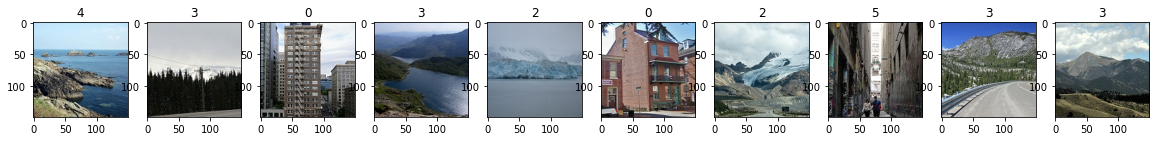

In [16]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
offset = 20
for idx, img in enumerate(batch[0][offset:offset+10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][offset+idx])

As we can see above the following numbers match the following catagories:

0. building
1. forest
2. mountain
3. sea
4. street

In [17]:
print("max:" , batch[0].max(), " and min: ", batch[0].min())

max: 255.0  and min:  0.0


In [18]:
data = data.map(lambda x, y: (x / 255.0, y))

In [89]:
test = test.map(lambda x, y: (x / 255.0, y))

In [20]:
data.as_numpy_iterator().next()[0].max(), data.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

In [21]:
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.2)

In [22]:
print(train_size, val_size)

88 22


In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

In [24]:
# Number of batches * 32 images
len(train), len(val), len(test)

(88, 22, 24)

In [25]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [26]:
logdir = r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\Log'

In [27]:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Combine the TensorBoard callback with the EarlyStopping callback
callbacks = [callback, early_stopping]

In [28]:
model= tf.keras.Sequential([
    # First layer
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Second layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [31]:
history = model.fit(train, epochs=20, validation_data = val, callbacks=[callback])

Epoch 1/20
88/88 [==============================] - 550s 6s/step - loss: 1.1419 - accuracy: 0.5477 - val_loss: 0.8694 - val_accuracy: 0.6610
Epoch 2/20
88/88 [==============================] - 446s 5s/step - loss: 0.7854 - accuracy: 0.7082 - val_loss: 0.7692 - val_accuracy: 0.7090
Epoch 3/20
88/88 [==============================] - 479s 5s/step - loss: 0.6530 - accuracy: 0.7610 - val_loss: 0.6242 - val_accuracy: 0.7722
Epoch 4/20
88/88 [==============================] - 491s 6s/step - loss: 0.5469 - accuracy: 0.8030 - val_loss: 0.5885 - val_accuracy: 0.7809
Epoch 5/20
88/88 [==============================] - 455s 5s/step - loss: 0.4564 - accuracy: 0.8375 - val_loss: 0.4987 - val_accuracy: 0.8357
Epoch 6/20
88/88 [==============================] - 451s 5s/step - loss: 0.3706 - accuracy: 0.8697 - val_loss: 0.5254 - val_accuracy: 0.8235
Epoch 7/20
88/88 [==============================] - 475s 5s/step - loss: 0.2918 - accuracy: 0.8976 - val_loss: 0.5397 - val_accuracy: 0.8173
Epoch 8/20
88

In [32]:
model.save(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\first_model_with_glacier_5.h5')

C:\Users\Maya\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


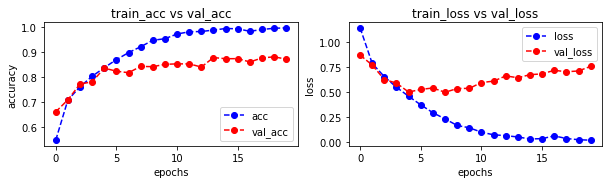

In [33]:
plot_accuracy_loss(history)

In [34]:
model = tf.keras.models.load_model(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\first_model_with_glacier_5.h5')

In [34]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch_test in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 6)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])


1/1 [==============================] - 1s 796ms/step


In [35]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9577, Recall: 0.9637, Accuracy:0.7973


In [36]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


24/24 [==============================] - 23s 870ms/step - loss: 1.1482 - accuracy: 0.7973
Test Loss: 1.1482244729995728, Test Accuracy: 0.7973333597183228


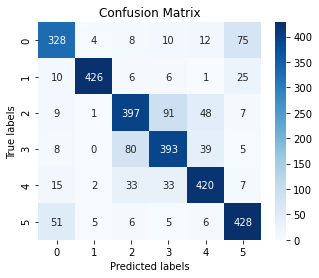

In [37]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Try to improve the VGG model

In [38]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# # Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [43]:
# Create the head model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(6, activation='softmax')(x) 

In [44]:
# Combine the base and head models
model_vgg_impr = Model(inputs=base_model.input, outputs=output)

In [45]:
# Compile the model
model_vgg_impr.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_vgg_impr.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [46]:
history_vgg_impr = model_vgg_impr.fit(train, epochs=15, validation_data = val, callbacks=[callbacks])

Epoch 1/15
88/88 [==============================] - 2178s 25s/step - loss: 0.4979 - accuracy: 0.8177 - val_loss: 0.3795 - val_accuracy: 0.8581
Epoch 2/15
88/88 [==============================] - 2807s 32s/step - loss: 0.2864 - accuracy: 0.8952 - val_loss: 0.3268 - val_accuracy: 0.8812
Epoch 3/15
88/88 [==============================] - 3126s 36s/step - loss: 0.2224 - accuracy: 0.9207 - val_loss: 0.3033 - val_accuracy: 0.8939
Epoch 4/15
88/88 [==============================] - 2849s 32s/step - loss: 0.1795 - accuracy: 0.9379 - val_loss: 0.3124 - val_accuracy: 0.8913
Epoch 5/15
88/88 [==============================] - 2007s 23s/step - loss: 0.1560 - accuracy: 0.9490 - val_loss: 0.4272 - val_accuracy: 0.8560
Epoch 6/15
88/88 [==============================] - 1792s 20s/step - loss: 0.1317 - accuracy: 0.9555 - val_loss: 0.3195 - val_accuracy: 0.8942


In [47]:
model_vgg_impr.save(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\vgg_model_impr_with_glacier_5.h5')

C:\Users\Maya\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [87]:
model_vgg_impr = tf.keras.models.load_model(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\vgg_model_impr_with_glacier_5.h5')

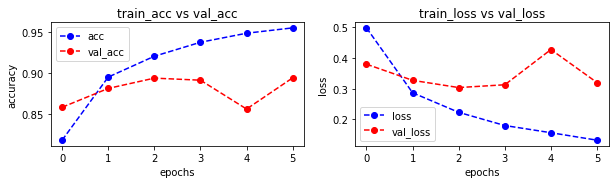

In [48]:
plot_accuracy_loss(history_vgg_impr)

In [54]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch_test in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg_impr.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 6)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])
    


1/1 [==============================] - 7s 7s/step


In [55]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9743, Recall: 0.9899, Accuracy:0.8740


In [52]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg_impr.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


24/24 [==============================] - 208s 9s/step - loss: 0.3751 - accuracy: 0.8740
Test Loss: 0.37509554624557495, Test Accuracy: 0.8740000128746033


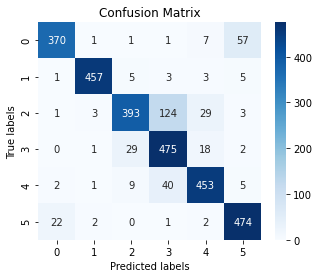

In [53]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

We can see a slight confusion between the building and street which is due to their similarities (even a human eye would have a hard time classifying some of the images presented). 
The other main confusion though is between the mountains and see which caused by the fact that they probabily both consisting of a lot of blue thereofore the model might have a difficulty classifying those 2.

# Try converting to 224x224

In [66]:
data_224 = tf.keras.utils.image_dataset_from_directory(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_train\seg_train', image_size = (224,224), batch_size=128)

Found 14034 files belonging to 6 classes.


In [67]:
test_224 = tf.keras.utils.image_dataset_from_directory(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_test\seg_test', image_size = (224,224), batch_size=128)

Found 3000 files belonging to 6 classes.


In [68]:
data_224 = data_224.map(lambda x, y: (x / 255.0, y))
test_224 = test_224.map(lambda x, y: (x / 255.0, y))

In [69]:
train_size = int(len(data_224)*0.8)
val_size = int(len(data_224)*0.2)

In [70]:
train_224 = data_224.take(train_size)
val_224 = data_224.skip(train_size).take(val_size)

In [73]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

# Load the VGG16 base model
base_model_224 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# # Freeze the layers in the base model
for layer in base_model_224.layers:
    layer.trainable = False

In [74]:
# Create the head model
x = Flatten()(base_model_224.output)
x = Dense(128, activation='relu')(x)
output = Dense(6, activation='softmax')(x) 

In [75]:
# Combine the base and head models
model_vgg_224 = Model(inputs=base_model_224.input, outputs=output)

In [76]:
# Compile the model
model_vgg_224.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_vgg_224.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [77]:
history_vgg_224 = model_vgg_224.fit(train_224, epochs=15, validation_data = val_224, callbacks=[callbacks])

Epoch 1/15
88/88 [==============================] - 14130s 162s/step - loss: 0.6454 - accuracy: 0.7795 - val_loss: 0.3629 - val_accuracy: 0.8675
Epoch 2/15
88/88 [==============================] - 18329s 210s/step - loss: 0.2786 - accuracy: 0.9047 - val_loss: 0.3103 - val_accuracy: 0.8935
Epoch 3/15
88/88 [==============================] - 2607s 30s/step - loss: 0.2104 - accuracy: 0.9295 - val_loss: 0.3004 - val_accuracy: 0.8874
Epoch 4/15
88/88 [==============================] - 2821s 32s/step - loss: 0.1653 - accuracy: 0.9457 - val_loss: 0.3022 - val_accuracy: 0.8964
Epoch 5/15
88/88 [==============================] - 2877s 33s/step - loss: 0.1371 - accuracy: 0.9541 - val_loss: 0.3352 - val_accuracy: 0.8801
Epoch 6/15
88/88 [==============================] - 2937s 33s/step - loss: 0.1010 - accuracy: 0.9701 - val_loss: 0.2786 - val_accuracy: 0.9072
Epoch 7/15
88/88 [==============================] - 2671s 30s/step - loss: 0.0919 - accuracy: 0.9712 - val_loss: 0.3009 - val_accuracy: 0.

In [78]:
model_vgg_224.save(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\vgg_model_224.h5')

C:\Users\Maya\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


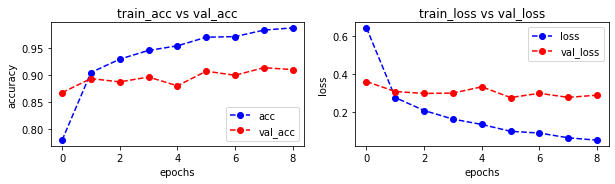

In [79]:
plot_accuracy_loss(history_vgg_224)

In [80]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch_test in test_224.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg_224.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 6)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])
    


1/1 [==============================] - 15s 15s/step


In [81]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9850, Recall: 0.9766, Accuracy:0.8820


In [85]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg_224.evaluate(test_224)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


24/24 [==============================] - 1232s 51s/step - loss: 0.3682 - accuracy: 0.8820
Test Loss: 0.36820879578590393, Test Accuracy: 0.8820000290870667


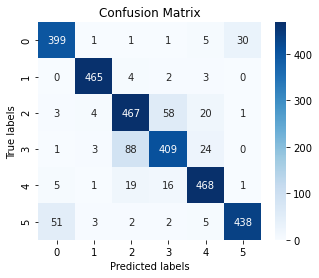

In [82]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()